## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
random.seed(0)

#### Funciones a usar

In [27]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_esp(path):
    return path[114]#path[110] prueba

def scaled_datas(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
        return mfccs_scaled_features
    except:
        print("rrrr-", file_name)


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        feature = features_extractor(path)
        files_filters[code]+= 1
        examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [28]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\data")
    emotions_code = ["t", "f"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_esp)
    examples = []
    files_filters = dict()
    files_filters["t"] = 0
    files_filters["f"] = 0
    examples = get_features(datas_files, get_code_esp, files_filters)
    return examples

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    datas = select_elements(entries, 't', 800,"without_stress")
    datas += select_elements(entries, 'f', 800, "stress")
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 1600 sobre 1600 audios.


In [30]:
X_train[0]

array([-2.03619125e+02,  1.32924957e+02,  1.16074324e+01,  4.22039948e+01,
        1.59348106e+01,  1.00078325e+01,  3.09595966e+00,  9.74628162e+00,
       -6.43884420e+00,  5.50276041e+00, -3.89752269e+00,  3.09939122e+00,
        1.09478855e+00,  3.97362924e+00,  1.78057158e+00,  6.92045116e+00,
        9.58635986e-01,  1.92379892e+00,  1.48452592e+00, -2.62816620e+00,
       -3.95873570e+00,  1.12830214e-01, -7.04381943e+00, -3.05793919e-02,
       -4.39929628e+00,  6.19296312e-01, -3.25743532e+00, -2.55520612e-01,
       -6.84725106e-01, -8.80580246e-01,  2.59195876e+00, -2.84970117e+00,
       -1.94983974e-01, -3.07813001e+00, -1.43103153e-01, -1.69904196e+00,
       -7.15058565e-01, -6.39670566e-02, -1.59365737e+00, -6.24961972e-01],
      dtype=float32)

In [31]:
'''
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
#    model.add(LSTM(units=16,input_shape= dim_entrada, return_sequences=True))
#    model.add(LSTM(units=4,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
    
    def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50, input_shape = dim_entrada))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
    
    tang_hiperbolica
'''
#redes neuronales recurrentes
#Datos son audios convertidos a MFCC 
#mayor accuracy o (porcentaje de aciertos) 


#probando nueva arquitectura
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

    return model


In [32]:
model = new_RNN()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_16 (LSTM)              (None, 40, 50)            20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 activation_5 (Activation)   (None, 50)                0         
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trai

In [33]:
#50 0.77
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []
'''
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]
'''
num_epochs = 100
num_batch_size = 128
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_19 (LSTM)              (None, 40, 50)            20200     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 activation_6 (Activation)   (None, 50)                0         
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trai

10/10 [==============================] - 4s 417ms/step - loss: 0.6244 - accuracy: 0.6172 - val_loss: 0.7131 - val_accuracy: 0.5406
Epoch 50/100
10/10 [==============================] - 4s 415ms/step - loss: 0.6320 - accuracy: 0.6234 - val_loss: 0.7160 - val_accuracy: 0.5906
Epoch 51/100
10/10 [==============================] - 4s 454ms/step - loss: 0.6165 - accuracy: 0.6344 - val_loss: 0.7102 - val_accuracy: 0.5656
Epoch 52/100
10/10 [==============================] - 5s 483ms/step - loss: 0.6118 - accuracy: 0.6375 - val_loss: 0.7340 - val_accuracy: 0.5625
Epoch 53/100
10/10 [==============================] - 4s 443ms/step - loss: 0.6096 - accuracy: 0.6484 - val_loss: 0.6860 - val_accuracy: 0.5969
Epoch 54/100
10/10 [==============================] - 5s 517ms/step - loss: 0.6058 - accuracy: 0.6273 - val_loss: 0.7070 - val_accuracy: 0.6000
Epoch 55/100
10/10 [==============================] - 5s 521ms/step - loss: 0.6068 - accuracy: 0.6258 - val_loss: 0.7084 - val_accuracy: 0.5813
Epoch

In [36]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

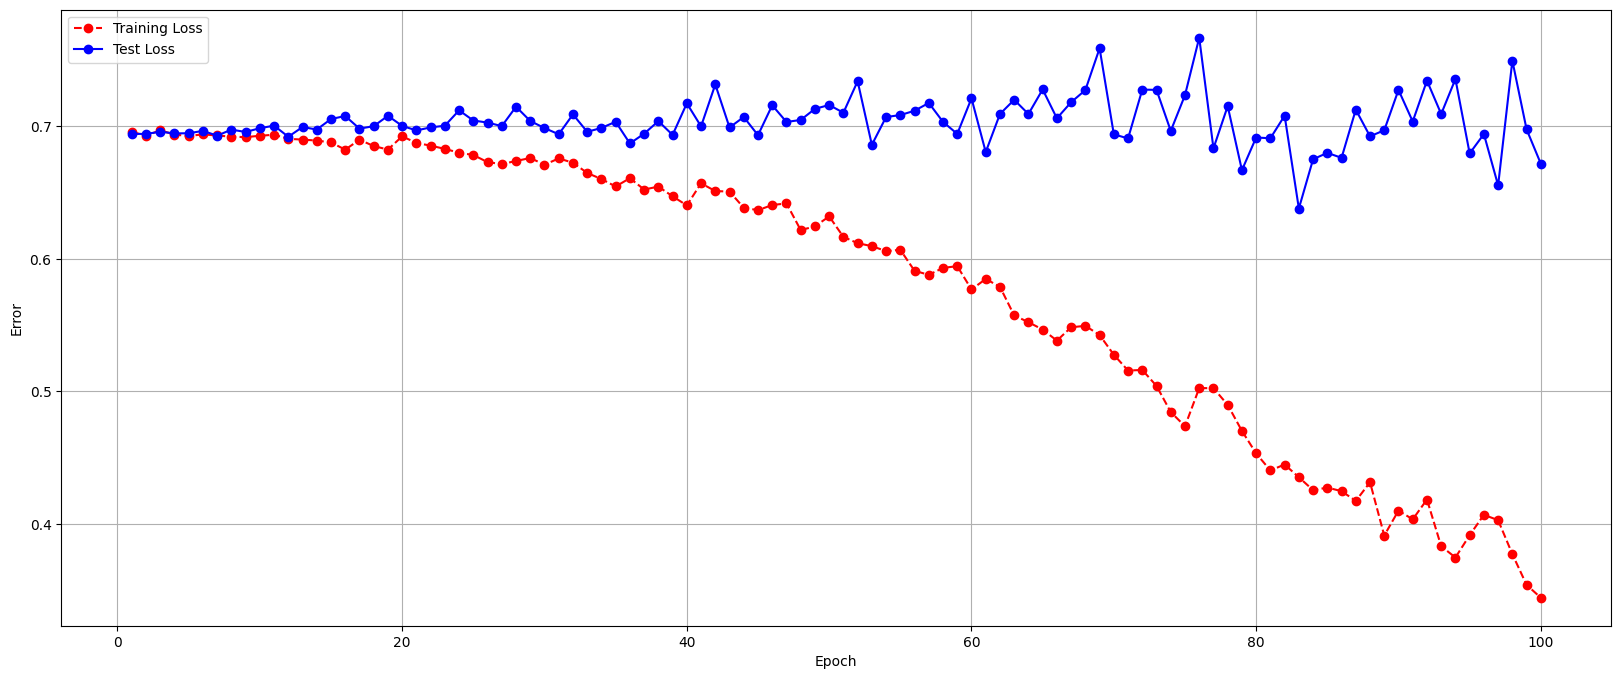

In [37]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.grid()
plt.show()

In [14]:
X_test[0:2].shape

(2, 40)

In [17]:
y_values = model.predict(X_test[0:1])

1/1 [==============================] - 0s 57ms/step


In [18]:
y_values

array([[0.80419517, 0.19580486]], dtype=float32)

In [27]:
#50 0.77
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []
'''
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]
'''
num_epochs = 80
num_batch_size = 200
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_22 (LSTM)              (None, 40, 50)            20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 activation_7 (Activation)   (None, 50)                0         
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trai

In [23]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

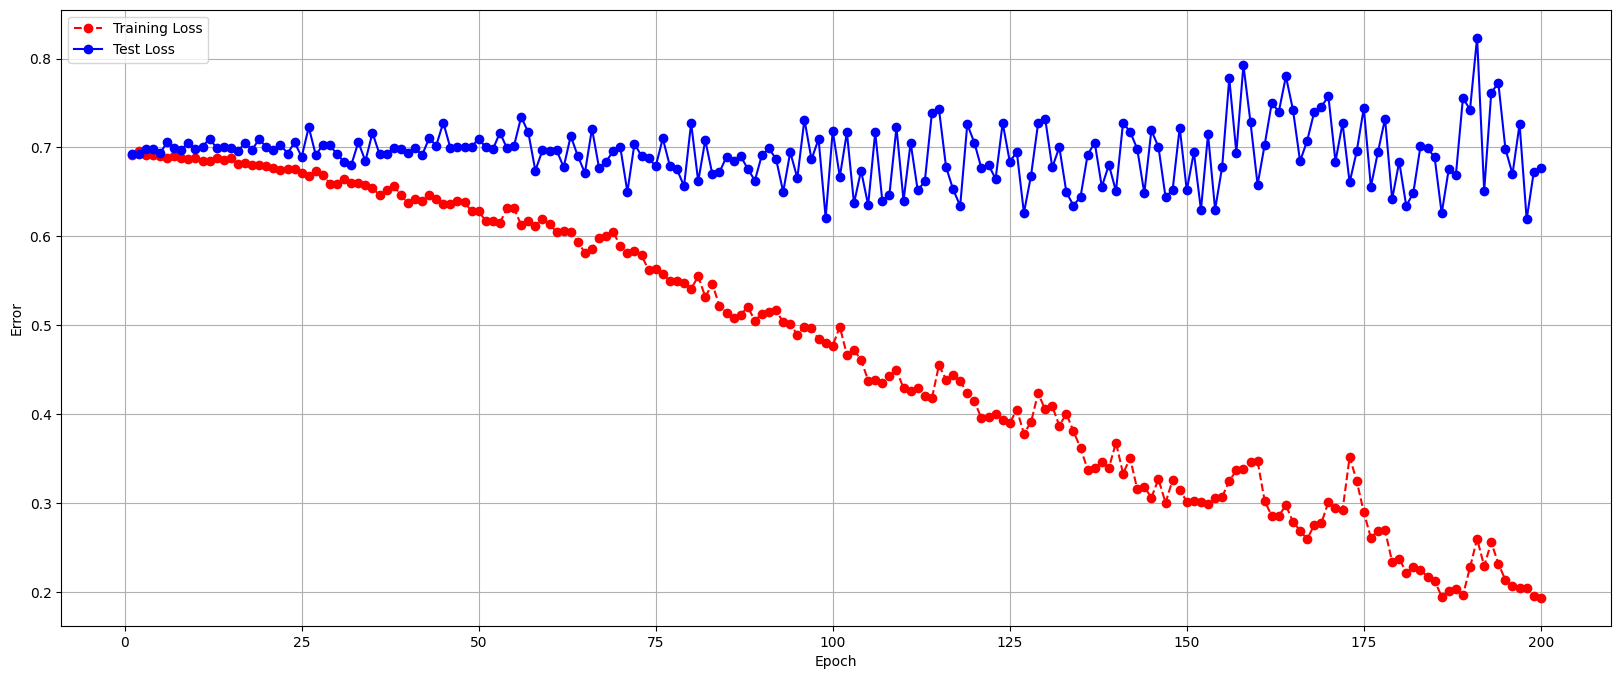

In [24]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.grid()
plt.show()

In [32]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 55
    num_batch_size = 200
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(1280, 40) y:(1280, 2)
Test - X:(320, 40) y:(320, 2)
Epoch 1/55
7/7 [==============================] - 24s 1s/step - loss: 0.6965 - accuracy: 0.5000 - val_loss: 0.7003 - val_accuracy: 0.4500
Epoch 2/55
7/7 [==============================] - 7s 975ms/step - loss: 0.6944 - accuracy: 0.5039 - val_loss: 0.7059 - val_accuracy: 0.4625
Epoch 3/55
7/7 [==============================] - 6s 896ms/step - loss: 0.6929 - accuracy: 0.5258 - val_loss: 0.7074 - val_accuracy: 0.4437
Epoch 4/55
7/7 [==============================] - 6s 820ms/step - loss: 0.6919 - accuracy: 0.5172 - val_loss: 0.7013 - val_accuracy: 0.4437
Epoch 5/55
7/7 [==============================] - 7s 1s/step - loss: 0.6935 - accuracy: 0.5031 - val_loss: 0.6990 - val_accuracy: 0.4437
Epoch 6/55
7/7 [==============================] - 7s 986ms/step - loss: 0.6920 - accuracy: 0.5148 - val_loss: 0.6971 - val_accuracy: 0.4437
Epoch 7/55
7/7 [==============================] - 6s 903ms/step - loss: 0.6922 - accuracy: 0.5

Epoch 2/55
7/7 [==============================] - 9s 1s/step - loss: 0.6939 - accuracy: 0.4883 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 3/55
7/7 [==============================] - 9s 1s/step - loss: 0.6925 - accuracy: 0.5102 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 4/55
7/7 [==============================] - 9s 1s/step - loss: 0.6934 - accuracy: 0.5117 - val_loss: 0.6924 - val_accuracy: 0.5125
Epoch 5/55
7/7 [==============================] - 9s 1s/step - loss: 0.6898 - accuracy: 0.5344 - val_loss: 0.6942 - val_accuracy: 0.4906
Epoch 6/55
7/7 [==============================] - 8s 1s/step - loss: 0.6914 - accuracy: 0.5227 - val_loss: 0.6940 - val_accuracy: 0.4969
Epoch 7/55
7/7 [==============================] - 9s 1s/step - loss: 0.6924 - accuracy: 0.5078 - val_loss: 0.6931 - val_accuracy: 0.5375
Epoch 8/55
7/7 [==============================] - 9s 1s/step - loss: 0.6913 - accuracy: 0.5219 - val_loss: 0.6930 - val_accuracy: 0.5063
Epoch 9/55
7/7 [=========================

7/7 [==============================] - 10s 1s/step - loss: 0.6927 - accuracy: 0.5102 - val_loss: 0.6919 - val_accuracy: 0.5219
Epoch 7/55
7/7 [==============================] - 11s 2s/step - loss: 0.6931 - accuracy: 0.5102 - val_loss: 0.6916 - val_accuracy: 0.5437
Epoch 8/55
7/7 [==============================] - 11s 2s/step - loss: 0.6931 - accuracy: 0.5102 - val_loss: 0.6905 - val_accuracy: 0.5344
Epoch 9/55
7/7 [==============================] - 10s 1s/step - loss: 0.6929 - accuracy: 0.5195 - val_loss: 0.6925 - val_accuracy: 0.5156
Epoch 10/55
7/7 [==============================] - 10s 1s/step - loss: 0.6921 - accuracy: 0.5117 - val_loss: 0.6919 - val_accuracy: 0.5500
Epoch 11/55
7/7 [==============================] - 10s 1s/step - loss: 0.6924 - accuracy: 0.5148 - val_loss: 0.6905 - val_accuracy: 0.5188
Epoch 12/55
7/7 [==============================] - 12s 2s/step - loss: 0.6929 - accuracy: 0.4969 - val_loss: 0.6910 - val_accuracy: 0.5656
Epoch 13/55
7/7 [=========================

7/7 [==============================] - 12s 2s/step - loss: 0.6906 - accuracy: 0.5508 - val_loss: 0.6977 - val_accuracy: 0.4812
Epoch 9/55
7/7 [==============================] - 13s 2s/step - loss: 0.6915 - accuracy: 0.5414 - val_loss: 0.7008 - val_accuracy: 0.4625
Epoch 10/55
7/7 [==============================] - 13s 2s/step - loss: 0.6880 - accuracy: 0.5328 - val_loss: 0.7006 - val_accuracy: 0.4844
Epoch 11/55
7/7 [==============================] - 12s 2s/step - loss: 0.6892 - accuracy: 0.5508 - val_loss: 0.7030 - val_accuracy: 0.4875
Epoch 12/55
7/7 [==============================] - 12s 2s/step - loss: 0.6869 - accuracy: 0.5445 - val_loss: 0.7031 - val_accuracy: 0.4688
Epoch 13/55
7/7 [==============================] - 12s 2s/step - loss: 0.6847 - accuracy: 0.5266 - val_loss: 0.7033 - val_accuracy: 0.4656
Epoch 14/55
7/7 [==============================] - 12s 2s/step - loss: 0.6841 - accuracy: 0.5516 - val_loss: 0.7033 - val_accuracy: 0.4594
Epoch 15/55
7/7 [=======================

In [72]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.7011466026306152 val_accuracy: 0.637499988079071
El algoritmo acerto 240 veces sobre los 320 casos.


In [32]:
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
#    model.add(LSTM(units=16,input_shape= dim_entrada, return_sequences=True))
#    model.add(LSTM(units=4,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8200663349917081
-----------------------
Resumen
Fold score (Accuracy score): 0.8281573498964804
Fold score (Accuracy score): 0.8Detector de la mentira usando redes neuronales recurrentes426501035196687
Fold score (Accuracy score): 0.8008298755186722
Fold score (Accuracy score): 0.8174273858921162
Fold score (Accuracy score): 0.8112033195020747
'''

'\nCross-validated score (Accuracy score): 0.8200663349917081\n-----------------------\nResumen\nFold score (Accuracy score): 0.8281573498964804\nFold score (Accuracy score): 0.8Detector de la mentira usando redes neuronales recurrentes426501035196687\nFold score (Accuracy score): 0.8008298755186722\nFold score (Accuracy score): 0.8174273858921162\nFold score (Accuracy score): 0.8112033195020747\n'

In [77]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
